In [1]:
import chess
import chess.engine
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np


1. Reprezentacja stanu

In [2]:
import numpy as np
import torch
import chess

# Mapa typów figur do indeksów
piece_to_index = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5
}

def get_attacked_squares(board, color):
    """
    Zwraca zbiór pól atakowanych przez daną stronę.
    """
    attacked = chess.SquareSet()
    for piece_type in piece_to_index.keys():
        for square in board.pieces(piece_type, color):
            attacked |= board.attacks(square)
    return attacked

def generate_bitboards(board):
    """
    Generuje bitboardy do upakowania w tensor, każdy bitboard reprezentuje różne typy figur i stany gry.
    """
    # 6 dla figur, 1 dla kontrolowanych pól, 4 dla praw roszady, 1 dla bicia w przelocie
    bitboards = np.zeros((12, 8, 8), dtype=np.float32)
    
    # Figury
    for piece_type, index in piece_to_index.items():
        # Białe figury
        white_squares = board.pieces(piece_type, chess.WHITE)
        for square in white_squares:
            row, col = divmod(square, 8)
            bitboards[index, row, col] = 1.0  # Białe jako +1

        # Czarne figury
        black_squares = board.pieces(piece_type, chess.BLACK)
        for square in black_squares:
            row, col = divmod(square, 8)
            bitboards[index, row, col] = -1.0  # Czarne jako -1
    
    # Kontrolowane pola
    controlled_squares = np.zeros((8, 8), dtype=np.float32)
    
    white_attacks = get_attacked_squares(board, chess.WHITE)
    for square in white_attacks:
        row, col = divmod(square, 8)
        controlled_squares[row, col] += 1.0
    
    black_attacks = get_attacked_squares(board, chess.BLACK)
    for square in black_attacks:
        row, col = divmod(square, 8)
        controlled_squares[row, col] -= 1.0
    
    bitboards[6] = controlled_squares  # Indeks 6 dla kontrolowanych pól
    
    # Prawa roszady
    # Indeks 7: Roszada krótka białych
    # Indeks 8: Roszada długa białych
    # Indeks 9: Roszada krótka czarnych
    # Indeks 10: Roszada długa czarnych
    bitboards[7, :, :] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    bitboards[8, :, :] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    bitboards[9, :, :] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    bitboards[10, :, :] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # Bicie w przelocie
    # Indeks 11: Pole celu bicia w przelocie
    bitboards[11, :, :] = 0.0
    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        bitboards[11, row, col] = 1.0  # Ustaw odpowiednie pole na 1.0
    
    return bitboards

# Pakuj bitboardy w tensor
def board_to_tensor(board):
    """
    Konwertuje obiekt chess.Board na tensor wejściowy dla sieci neuronowej.
    
    Parametry:
    - board: Obiekt chess.Board reprezentujący aktualny stan gry.
    
    Zwraca:
    - Tensor o kształcie [12, 8, 8], gdzie 12 kanałów odpowiada 6 typom figur dla każdego koloru.
    """
    piece_map = board.piece_map()
    tensor = torch.zeros(12, 8, 8)
    
    piece_to_channel = {
        'P': 0,  # White Pawn
        'N': 1,  # White Knight
        'B': 2,  # White Bishop
        'R': 3,  # White Rook
        'Q': 4,  # White Queen
        'K': 5,  # White King
        'p': 6,  # Black Pawn
        'n': 7,  # Black Knight
        'b': 8,  # Black Bishop
        'r': 9,  # Black Rook
        'q': 10, # Black Queen
        'k': 11  # Black King
    }
    
    for square, piece in piece_map.items():
        row = 7 - (square // 8)
        col = square % 8
        channel = piece_to_channel[piece.symbol()]
        tensor[channel, row, col] = 1.0
    
    return tensor

def index_to_move(board, channel, idx):
    """
    Konwertuje indeks akcji na obiekt chess.Move na podstawie kanału i indeksu.
    
    Parametry:
    - board: Obiekt chess.Board reprezentujący aktualny stan gry.
    - channel: Numer kanału akcji (0-4).
    - idx: Indeks akcji w kanale (0-4095).
    
    Zwraca:
    - Obiekt chess.Move odpowiadający indeksowi, lub None jeśli ruch jest nielegalny.
    """
    from_square = idx // 64
    to_square = idx % 64
    move = chess.Move(from_square, to_square)
    
    # Sprawdzenie legalności ruchu
    if move in board.legal_moves:
        return move
    else:
        return None


# Przykładowe użycie
# board = chess.Board()
# tensor = board_to_tensor(board)
# print("Kształt tensora:", tensor.shape)  # Powinno być (12, 8, 8)


In [3]:

# Nowa plansza
board = chess.Board()

# Stan planszy jako tensor
state_tensor = board_to_tensor(board)

# Rozmiar tensora
print("Kształt tensora stanów: ", state_tensor.shape)  # [7, 8, 8] (na razie)
state_tensor

Kształt tensora stanów:  torch.Size([12, 8, 8])


tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
       

2. Przestrzeń możliwych działań

In [4]:

def get_action_mask(board):
    """
    Tworzy maskę akcji, która wskazuje, które ruchy są legalne.
    
    Parametry:
    - board: Obiekt chess.Board reprezentujący aktualny stan gry.
    
    Zwraca:
    - Tensor o kształcie [5, 4096], gdzie każdy z 5 kanałów odpowiada typowi ruchu.
      Wartość 1 oznacza, że dany ruch jest legalny, 0 w przeciwnym przypadku.
    """
    action_mask = torch.zeros(5, 4096)
    
    # Mapping kanałów do typów figur
    piece_type_to_channel = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4
        # King moves mogą być dodane jako osobny kanał, jeśli potrzebne
    }
    
    for move in board.legal_moves:
        piece = board.piece_at(move.from_square)
        if piece is None:
            continue
        piece_type = piece.piece_type
        if piece_type not in piece_type_to_channel:
            continue  # Ignorujemy ruchy króla lub inne nietypowe ruchy
        channel = piece_type_to_channel[piece_type]
        
        # Konwersja ruchu na unikalny indeks w ramach kanału
        # Możemy użyć prostego mapowania: from_square * 64 + to_square
        from_square = move.from_square
        to_square = move.to_square
        action_idx = from_square * 64 + to_square
        if action_idx < 4096:
            action_mask[channel, action_idx] = 1.0
    
    return action_mask


# Przykładowe użycie
# board = chess.Board()
# action_mask = get_action_mask(board)
# print("Kształt maski akcji:", action_mask.shape)  # Powinno być (5, 8, 8, 8, 8)
# action_mask


3. Architektura sieci neuronowej

In [5]:
class MaskLayer(nn.Module):
    def __init__(self):
        super(MaskLayer, self).__init__()
    
    def forward(self, x, mask):
        return torch.mul(x, mask)

class ResidualBlock(nn.Module):
    """
    Standardowy blok resztkowy z dwiema warstwami konwolucyjnymi i połączeniem pomijającym.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip = nn.Identity()
        
    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class LuigiCNN(nn.Module):
    def __init__(self, action_channels=5):
        super(LuigiCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=12, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Dodanie bloków resztkowych
        self.residual_blocks = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256),
            ResidualBlock(256, 256)
        )
        
        self.conv_final = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_final = nn.BatchNorm2d(256)
        
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, action_channels * 8 * 8 * 8 * 8)  # Rozmiar wyjściowy dostosowany do wielu kanałów
        
        self.mask_layer = MaskLayer()
        
    def forward(self, x, action_mask):
        batch_size = x.size(0)
        
        x = F.relu(self.bn1(self.conv1(x)))  # [batch_size, 64, 8, 8]
        x = self.residual_blocks(x)          # [batch_size, 256, 8, 8]
        x = F.relu(self.bn_final(self.conv_final(x)))  # [batch_size, 256, 8, 8]
        
        x = self.global_pool(x).view(batch_size, -1)  # [batch_size, 256]
        
        x = F.relu(self.fc1(x))        # [batch_size, 1024]
        x = self.fc2(x)                # [batch_size, action_channels * 4096]
        
        x = x.view(batch_size, 5, 8, 8, 8, 8)  # [batch_size, 5, 8, 8, 8, 8]
        
        # Przekształcenie wyjścia do [batch_size, 5, 4096]
        x = x.view(batch_size, 5, -1)  # [batch_size, 5, 4096]
        action_mask = action_mask.view(batch_size, 5, -1)  # [batch_size, 5, 4096]
        
        # Zastosowanie maski
        x = x * action_mask  # [batch_size, 5, 4096]
        
        return x  # Logits


4. Sygnał nagrody - Nagrodę definiujemy jako zwiększenie ewaluacji pozycji przez stockfisha w stosunku do poprzedniej tury.


In [6]:
def get_stockfish_evaluation(board, stockfish_engine, time_limit=0.1):
    """
    Uzyskuje ocenę pozycji od silnika Stockfish.

    Parametry:
    - board: Obiekt chess.Board reprezentujący aktualny stan gry.
    - stockfish_engine: Obiekt silnika Stockfish (instancja chess.engine.SimpleEngine).
    - time_limit: Czas w sekundach na przemyślenie ruchu przez Stockfish.

    Zwraca:
    - Ocena pozycji w punktach (centipawnach).
      Dodatnia wartość oznacza przewagę białych, ujemna przewagę czarnych.
    """
    try:
        result = stockfish_engine.analyse(board, limit=chess.engine.Limit(depth=5))
        score = result["score"].white().score(mate_score=10000)
        return score
    except Exception as e:
        print("Błąd podczas analizy przez Stockfish:", e)
        return None

def agent_random_move(board):
    """
    Wybiera losowy ruch dla agenta.

    Parametry:
    - board: Obiekt chess.Board reprezentujący aktualny stan gry.

    Zwraca:
    - Wybrany ruch jako obiekt chess.Move.
    """
    legal_moves = list(board.legal_moves)
    if not legal_moves:
        return None
    return random.choice(legal_moves)

def calculate_reward(previous_eval, current_eval, agent_color, min_eval=-1000.0, max_eval=1000.0):
    """
    Oblicza i normalizuje nagrodę na podstawie zmiany oceny pozycji.
    
    Parametry:
    - previous_eval: Ocena pozycji przed wykonaniem ruchu (centipawnów).
    - current_eval: Ocena pozycji po wykonaniu ruchu (centipawnów).
    - agent_color: Kolor agenta (chess.WHITE lub chess.BLACK).
    - min_eval: Minimalna oczekiwana zmiana oceny (centipawnów).
    - max_eval: Maksymalna oczekiwana zmiana oceny (centipawnów).
    
    Zwraca:
    - Nagrodę w zakresie [-1, 1].
      +1 oznacza największą możliwą poprawę pozycji.
      -1 oznacza największą możliwą utratę pozycji.
    """
    if previous_eval is None or current_eval is None:
        return 0.0

    # Obliczenie zmiany oceny w zależności od koloru agenta
    if agent_color == chess.WHITE:
        raw_reward = current_eval - previous_eval
    else:
        raw_reward = previous_eval - current_eval

    # Klipowanie nagrody do zakresu [min_eval, max_eval]
    raw_reward = max(min(raw_reward, max_eval), min_eval)

    # Normalizacja nagrody do zakresu [-1, 1]
    normalized_reward = raw_reward / max_eval

    # Upewnienie się, że nagroda mieści się w [-1, 1]
    normalized_reward = np.clip(normalized_reward, -1.0, 1.0)

    return float(normalized_reward)


6. Agent i środowisko

In [7]:
class ChessEnvironment:
    def __init__(self, agent_color=chess.WHITE, stockfish_path="../stockfish/stockfish-ubuntu-x86-64", max_eval=1000.0):
        self.agent_color = agent_color
        self.board = chess.Board()
        self.stockfish = chess.engine.SimpleEngine.popen_uci(stockfish_path)
        self.previous_eval = get_stockfish_evaluation(self.board, self.stockfish)
        self.total_reward = 0.0
        self.max_eval = max_eval

    def reset(self):
        self.board.reset()
        self.previous_eval = get_stockfish_evaluation(self.board, self.stockfish)
        self.total_reward = 0.0
        return board_to_tensor(self.board)

    def step(self, move):
        self.board.push(move)
        current_eval = get_stockfish_evaluation(self.board, self.stockfish)
        reward = calculate_reward(previous_eval=self.previous_eval, 
                                  current_eval=current_eval, 
                                  agent_color=self.agent_color, 
                                  max_eval=self.max_eval)
        self.total_reward += reward
        done = self.board.is_game_over()
        info = {"result": self.board.result()}
        next_state = board_to_tensor(self.board)
        self.previous_eval = current_eval
        return next_state, reward, done, info

    def close(self):
        self.stockfish.quit()

class ChessAgent:
    def __init__(self, lr=1e-4, gamma=0.99, agent_color=chess.WHITE, device='cpu'):
        self.device = device
        self.model = LuigiCNN(action_channels=5).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = gamma
        self.agent_color = agent_color
        
        # Przechowywanie log-probability i nagród
        self.log_probs = []
        self.rewards = []
    
    def select_move(self, state, action_mask, board):
        self.model.train()
        state = state.to(self.device)
        action_mask = action_mask.to(self.device)
        
        logits = self.model(state, action_mask)  # [1, 5, 4096]
        logits = logits.view(-1)  # [20480]
        mask = action_mask.view(-1)  # [20480]
        
        # Zastosowanie maski: ustawienie bardzo niskich wartości dla nielegalnych ruchów
        masked_logits = logits * mask + (mask == 0).float() * (-1e10)
        
        probs = F.softmax(masked_logits, dim=0)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        self.log_probs.append(m.log_prob(action))
        
        # Konwersja indeksu do ruchu
        channel = action.item() // 4096
        idx = action.item() % 4096
        move = index_to_move(board, channel, idx)
        return move

    def remember(self, reward):
        self.rewards.append(reward)
    
    def learn(self):
        if not self.rewards:
            return  # Brak nagród do nauki

        # Obliczenie dyskontowanych nagród
        discounted_rewards = []
        R = 0
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            discounted_rewards.insert(0, R)

        # Normalizacja nagród
        discounted_rewards = torch.tensor(discounted_rewards, device=self.device)
        if discounted_rewards.std() != 0:
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        # Obliczenie strat
        policy_loss = []
        for log_prob, reward in zip(self.log_probs, discounted_rewards):
            policy_loss.append(-log_prob * reward)
        policy_loss = torch.stack(policy_loss).sum()

        # Aktualizacja modelu
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        # Resetowanie pamięci
        self.log_probs = []
        self.rewards = []
        
    def save_model(self, filepath, episode=None, rewards_history=None):
        """
        Zapisuje stan modelu i optymalizatora do pliku.
        
        Parametry:
        - filepath: Ścieżka do pliku, w którym zapisany zostanie model.
        - episode: (Opcjonalnie) Numer epizodu treningowego.
        - rewards_history: (Opcjonalnie) Historia nagród z treningu.
        """
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'gamma': self.gamma,
            'agent_color': self.agent_color,
            'log_probs': self.log_probs,
            'rewards': self.rewards
        }
        if episode is not None:
            checkpoint['episode'] = episode
        if rewards_history is not None:
            checkpoint['rewards_history'] = rewards_history
        torch.save(checkpoint, filepath)
        print(f"Model zapisany do {filepath}")

    def load_model(self, filepath):
        """
        Ładuje stan modelu i optymalizatora z pliku.
        
        Parametry:
        - filepath: Ścieżka do pliku, z którego zostanie załadowany model.
        """
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.gamma = checkpoint.get('gamma', self.gamma)
        self.agent_color = checkpoint.get('agent_color', self.agent_color)
        self.log_probs = checkpoint.get('log_probs', [])
        self.rewards = checkpoint.get('rewards', [])
        print(f"Model załadowany z {filepath}")



7. Uczenie agenta

In [8]:
def train_agent(num_episodes=1000, max_moves=100, agent_color=chess.WHITE, device='cpu',
                save_every=100, save_path='../data/chess_agent_checkpoint.pth', load_checkpoint=None):
    agent = ChessAgent(agent_color=agent_color, device=device)
    env = ChessEnvironment(agent_color=agent_color)
    
    rewards_history = []  # Lista do przechowywania nagród z każdego epizodu
    moving_avg = []       # Lista do przechowywania średniej nagród
    window_size = 50      # Rozmiar okna dla średniej nagród
    
    # Jeśli podano ścieżkę do checkpointa, załaduj model
    if load_checkpoint is not None:
        agent.load_model(load_checkpoint)
        # Możesz również załadować historię nagród, jeśli jest dostępna
        checkpoint = torch.load(load_checkpoint, map_location=device)
        rewards_history = checkpoint.get('rewards_history', [])
    
    try:
        for episode in range(1, num_episodes + 1):
            print(f"--- Episode {episode} ---")
            board = chess.Board()
            move_count = 0
            total_reward = 0.0
            previous_eval = get_stockfish_evaluation(board, env.stockfish)
            
            while not board.is_game_over() and move_count < max_moves:
                print(board)
                print("\nAktualny ruch:", move_count + 1)
            
                if board.turn == agent_color:
                    # Przygotowanie stanu
                    state = board_to_tensor(board).unsqueeze(0).float().to(agent.device)  # [1, 12, 8, 8]
                    action_mask = get_action_mask(board).view(-1).to(agent.device)  # [20480]
            
                    # Wybór ruchu przez agenta
                    move = agent.select_move(state, action_mask, board)
                    player = "Agent (Białe)" if agent_color == chess.WHITE else "Agent (Czarne)"
                else:
                    # Stockfish wykonuje ruch przeciwnika
                    result = env.stockfish.play(board, chess.engine.Limit(time=0.1))
                    move = result.move
                    player = "Stockfish (Czarne)" if agent_color == chess.WHITE else "Stockfish (Białe)"
            
                if move is None:
                    print("Brak dostępnych ruchów.")
                    break
            
                print(f"{player} wykonuje ruch: {board.san(move)}")
                board.push(move)
            
                # Uzyskanie oceny pozycji po ruchu
                current_eval = get_stockfish_evaluation(board, env.stockfish)
                if current_eval is not None:
                    print(f"Ocena Stockfish: {current_eval} centipawnów")
                else:
                    print("Brak oceny Stockfish.")
            
                # Obliczenie nagrody z normalizacją
                reward = calculate_reward(previous_eval=previous_eval, 
                                          current_eval=current_eval, 
                                          agent_color=agent_color)
                print(f"Nagroda: {reward} (normalizowana)\n")
            
                # Przechowywanie nagrody
                agent.remember(reward)
                total_reward += reward
            
                # Aktualizacja poprzedniej oceny
                previous_eval = current_eval
            
                move_count += 1
            
            print("Gra zakończona.")
            print("Finalny wynik:", board.result())
            print(f"Całkowita nagroda: {total_reward} (sumaryczna nagroda z normalizacją)")
            
            # Dodanie nagrody do historii
            rewards_history.append(total_reward)
            
            # Opcjonalnie: Obliczenie średniej nagród
            if episode >= window_size:
                avg_reward = np.mean(rewards_history[-window_size:])
                moving_avg.append(avg_reward)
            else:
                avg_reward = np.mean(rewards_history)
                moving_avg.append(avg_reward)
            
            # Sprawdzenie, czy obecna średnia jest najlepsza
            if avg_reward > (np.max(rewards_history[-window_size:]) if window_size <= len(rewards_history) else -float('inf')):
                agent.save_model(filepath='best_' + save_path, episode=episode, rewards_history=rewards_history)
                print(f"Nowy najlepszy model zapisany do best_{save_path}")
            
            # Trenowanie agenta po zakończeniu gry
            agent.learn()
            print("Model został zaktualizowany na podstawie doświadczeń.\n")
            
            # Zapis modelu co 'save_every' epizodów
            if episode % save_every == 0:
                agent.save_model(filepath=save_path, episode=episode, rewards_history=rewards_history)
    
    except KeyboardInterrupt:
        print("Trening przerwany przez użytkownika.")
    except Exception as e:
        print(f"Wystąpił błąd: {e}")
    finally:
        # Zamknięcie silnika Stockfish po zakończeniu treningu
        env.close()
        print("Silnik Stockfish został zamknięty.")
    
    # Zwrócenie historii nagród i średnich nagród
    return rewards_history, moving_avg


8. Monitorowanie procesu uczenia

--- Episode 1 ---
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R

Aktualny ruch: 1
Agent (Białe) wykonuje ruch: g4
Ocena Stockfish: -100 centipawnów
Nagroda: -0.149 (normalizowana)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . P .
. . . . . . . .
P P P P P P . P
R N B Q K B N R

Aktualny ruch: 2
Stockfish (Czarne) wykonuje ruch: d5
Ocena Stockfish: -134 centipawnów
Nagroda: -0.034 (normalizowana)

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . P .
. . . . . . . .
P P P P P P . P
R N B Q K B N R

Aktualny ruch: 3
Agent (Białe) wykonuje ruch: b3
Ocena Stockfish: -256 centipawnów
Nagroda: -0.122 (normalizowana)

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . P .
. P . . . . . .
P . P P P P . P
R N B Q K B N R

Aktualny ruch: 4
Stockfish (Czarne) wykonuje ruch: Bxg4
Ocena Stockfish: -263 centipawnów
Nagroda: -0.007 (normal

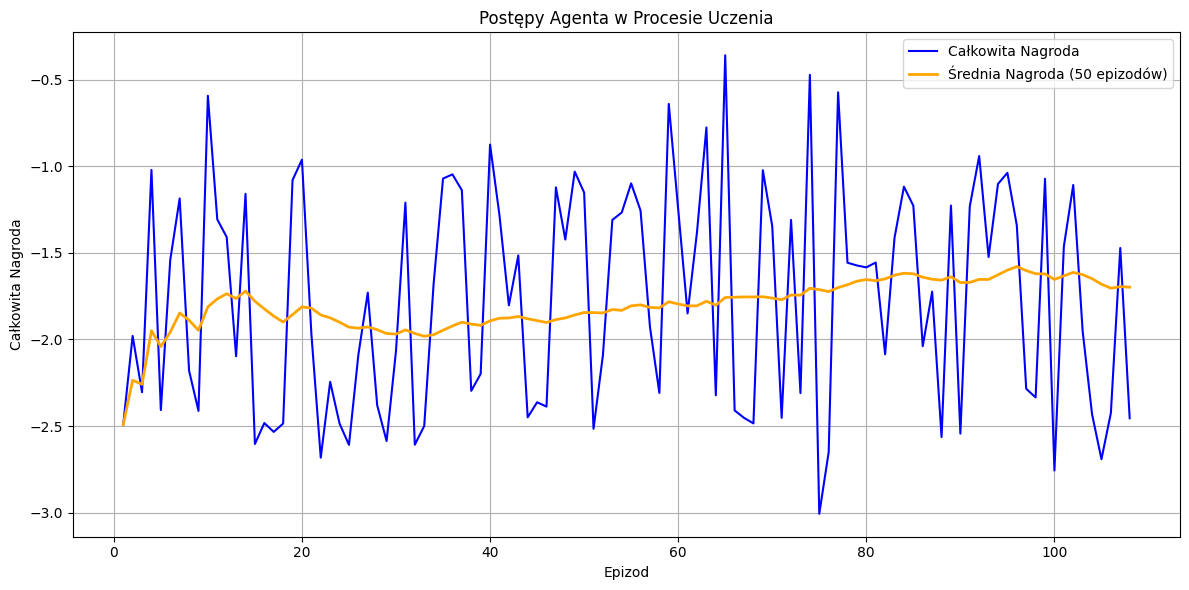

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Ustawienia treningu
NUM_EPISODES = 1000 # Liczba epizodów do treningu
MAX_MOVES = 100      # Maksymalna liczba ruchów w grze
AGENT_COLOR = chess.WHITE  # Kolor agenta (chess.WHITE lub chess.BLACK)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Użyj GPU, jeśli jest dostępne

# Ścieżka do pliku zapisu modelu
SAVE_PATH = 'chess_agent_checkpoint.pth'

# Opcjonalnie: Ścieżka do pliku z zapisanym modelem do załadowania
LOAD_CHECKPOINT = None  # np. 'chess_agent_checkpoint.pth'

# Rozpoczęcie treningu i przypisanie wyników
rewards_history, moving_avg = train_agent(num_episodes=NUM_EPISODES, 
                                         max_moves=MAX_MOVES, 
                                         agent_color=AGENT_COLOR, 
                                         device=DEVICE, 
                                         save_every=100, 
                                         save_path=SAVE_PATH, 
                                         load_checkpoint=LOAD_CHECKPOINT)

# Sprawdzenie, czy zmienne rewards_history i moving_avg są dostępne
if 'rewards_history' in globals() and 'moving_avg' in globals():
    episodes = range(1, len(rewards_history) + 1)
    plt.figure(figsize=(12, 6))
    
    # Wykres całkowitej nagrody
    plt.plot(episodes, rewards_history, label='Całkowita Nagroda', color='blue')
    
    # Wykres średniej nagrody (moving average)
    plt.plot(episodes, moving_avg, label='Średnia Nagroda (50 epizodów)', color='orange', linewidth=2)
    
    # Dodatkowe elementy wykresu
    plt.xlabel('Epizod')
    plt.ylabel('Całkowita Nagroda')
    plt.title('Postępy Agenta w Procesie Uczenia')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
elif 'rewards_history' in globals():
    # Jeśli dostępna jest tylko rewards_history
    episodes = range(1, len(rewards_history) + 1)
    plt.figure(figsize=(12, 6))
    
    plt.plot(episodes, rewards_history, label='Całkowita Nagroda', color='blue')
    
    plt.xlabel('Epizod')
    plt.ylabel('Całkowita Nagroda')
    plt.title('Postępy Agenta w Procesie Uczenia')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
else:
    print("Brak danych do wizualizacji. Upewnij się, że zmienne 'rewards_history' i/lub 'moving_avg' są dostępne.")
